Surface data file loaded: /Users/william/Desktop/Thesis-AES/Data/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Cementing Unit_Data.txt
Downhole data file loaded: /Users/william/Desktop/Thesis-AES/Data/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Downhole Gauge_Data.TXT
surface time min/max: (Timestamp('2023-12-10 14:42:58'), Timestamp('2023-12-10 17:33:17'))
downhole time min/max: (Timestamp('2023-12-09 21:24:09'), Timestamp('2023-12-11 01:33:42'))
Estimated delay: 1.03 h
Auto-detected shut-in (surface clock): 2023-12-10 17:15:24
[SURFACE] Falloff samples (capped): 181; duration = 180.0 s
Detected 3 cycles.

Per-cycle closure analysis on SURFACE pressure (Bourdet, √t & G within 0–180 s):
  Cycle 1: FCP (√t inters.) ≈ 315.51 bar at t ≈ 28 s
            FCP (G inters.)  ≈ 315.51 bar at t ≈ 12 s (tp=459s)
  Cycle 1: FCP (Bourdet) ≈ 316.51 bar at t ≈ 168 s (ended by restart, window 180s)
            FCP (√t)      ≈ 343.51 bar at t ≈ 6 s
            FCP (G-func)  ≈ 315.51 b

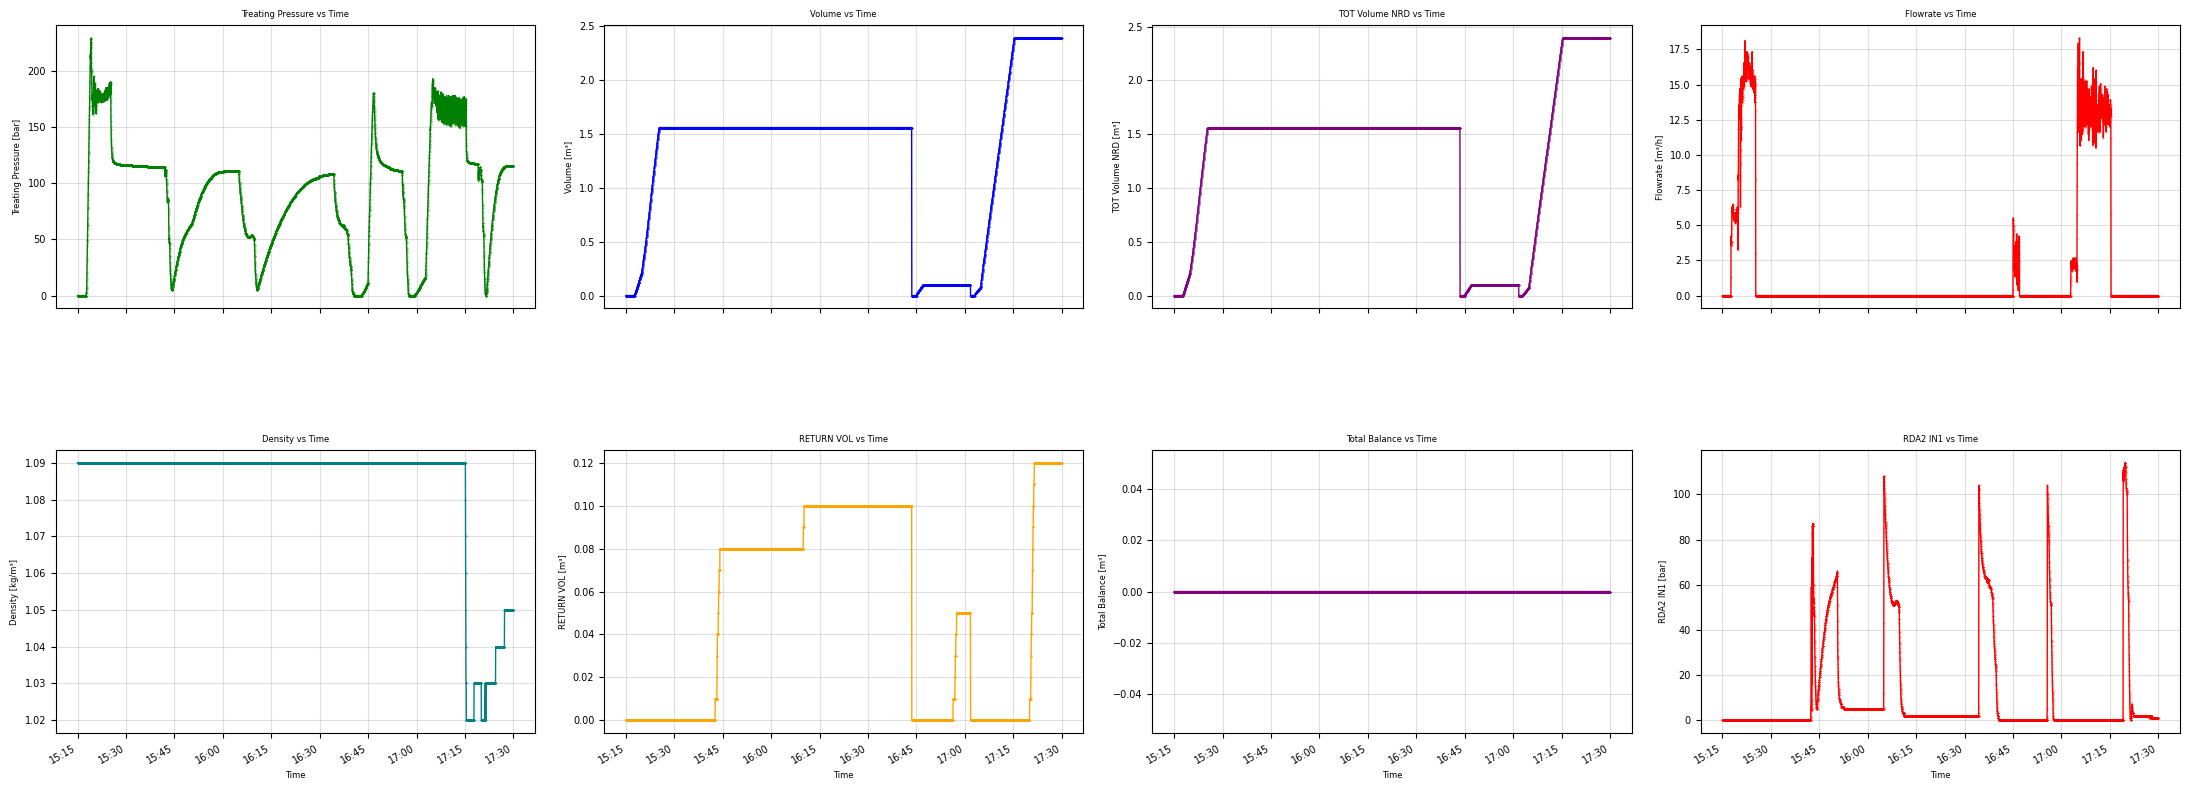

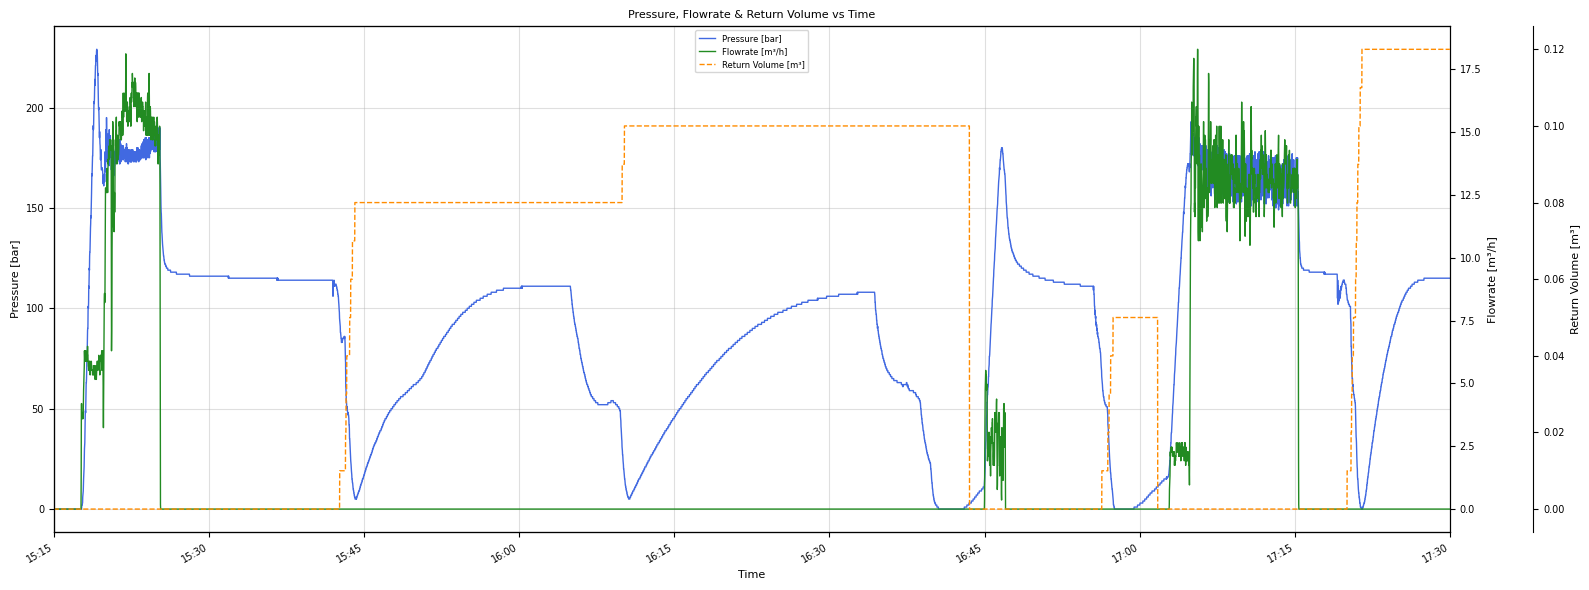

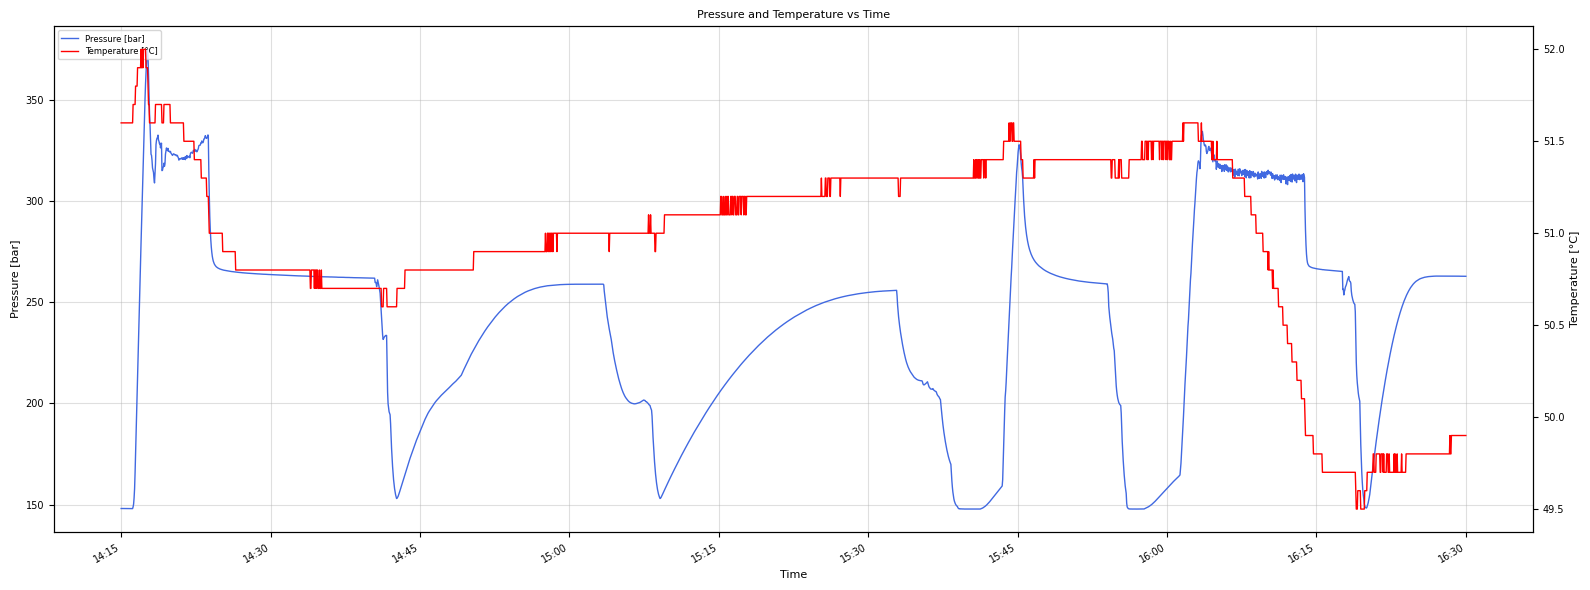

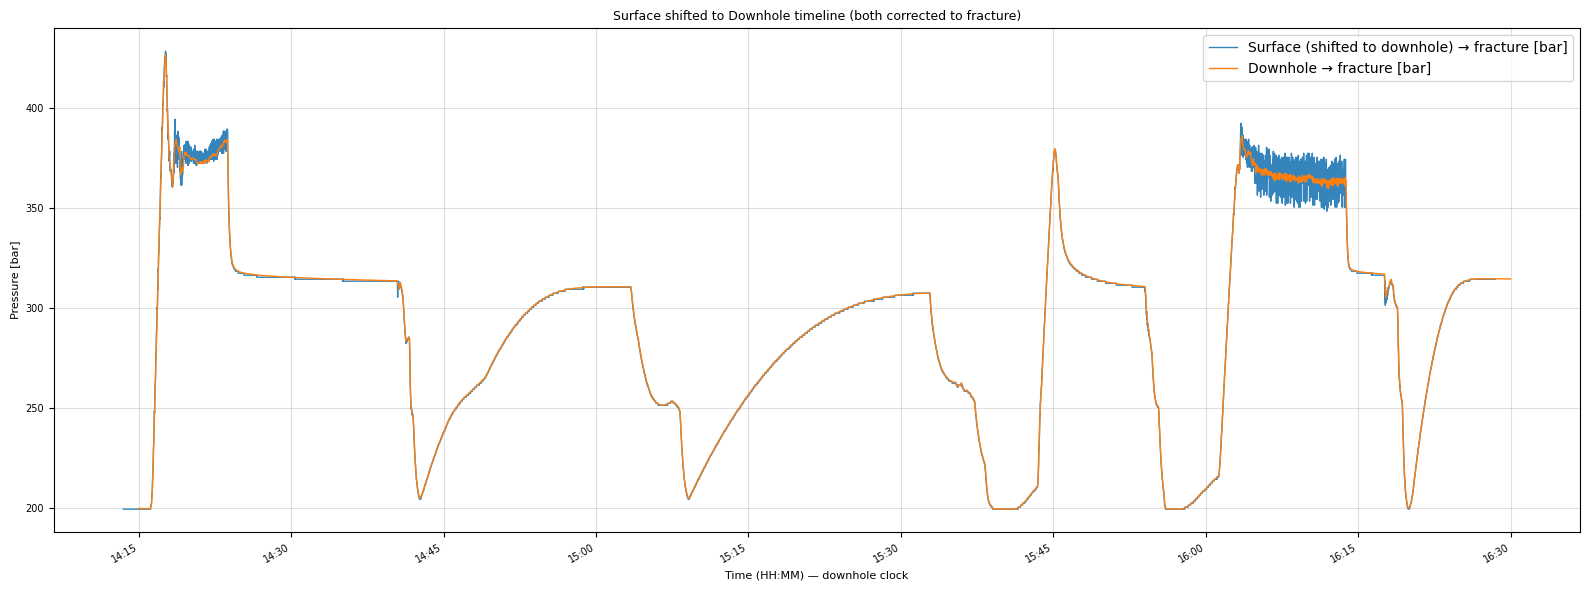

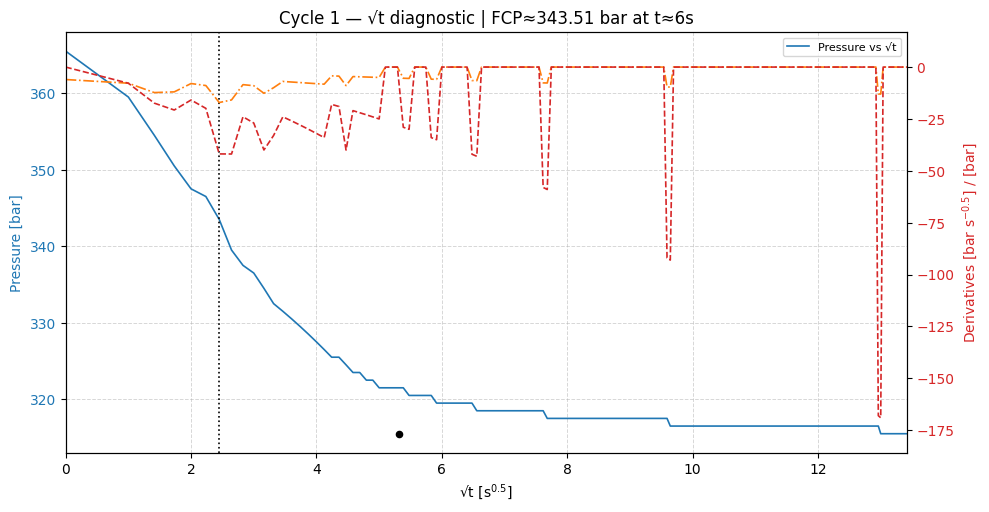

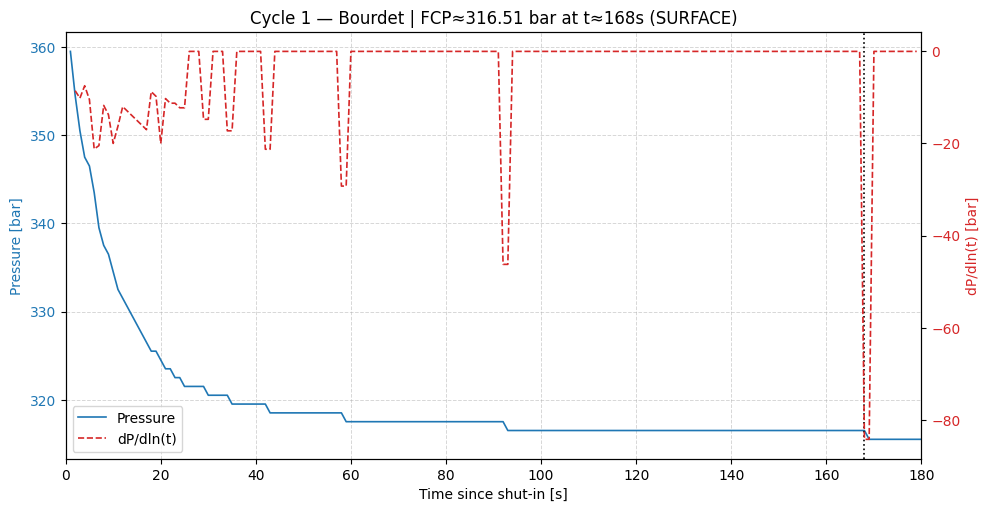

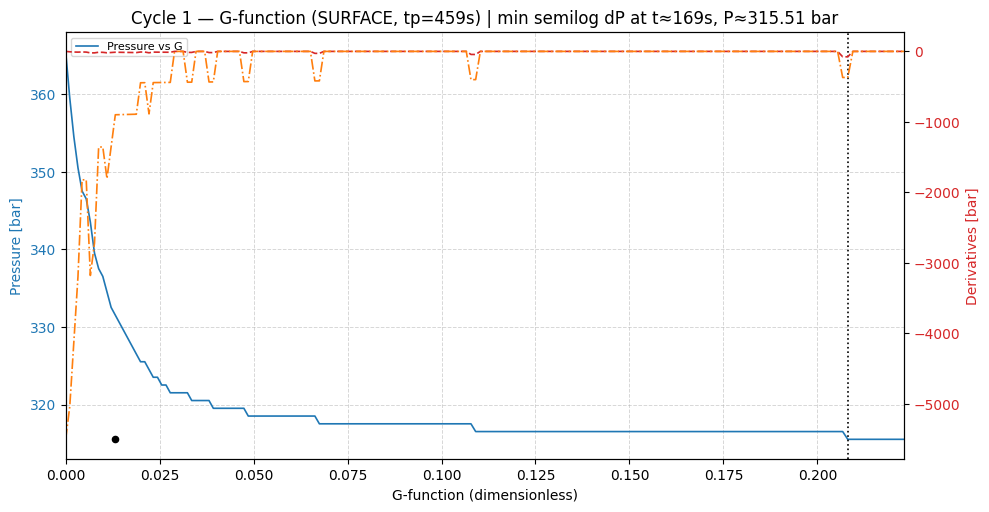

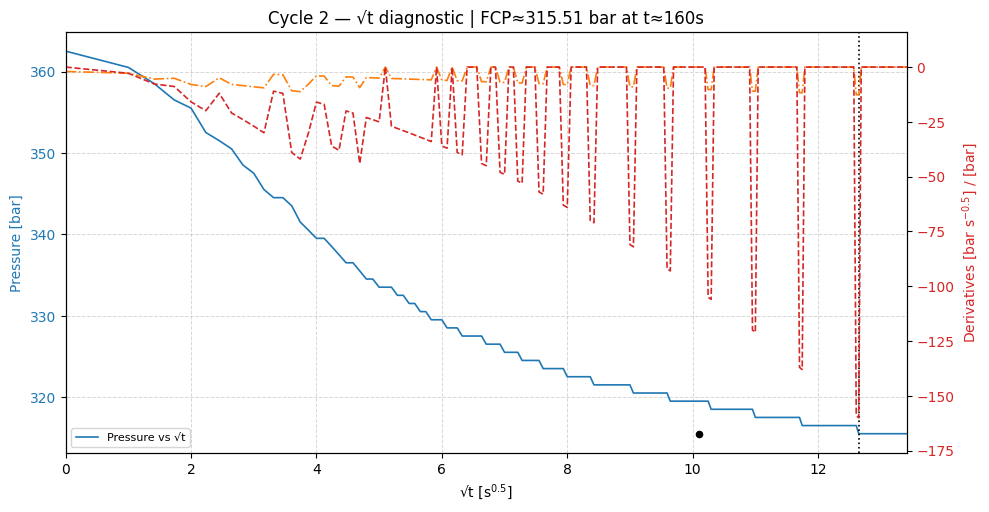

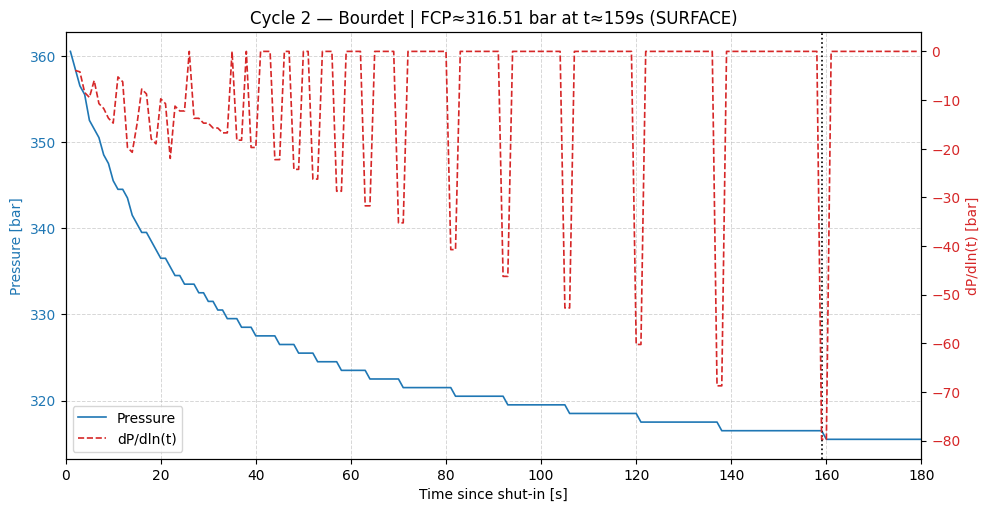

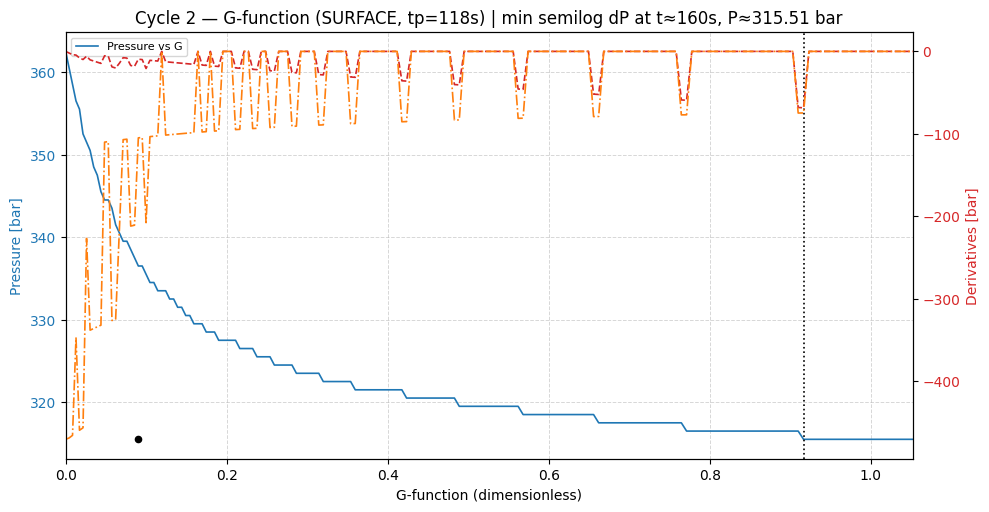

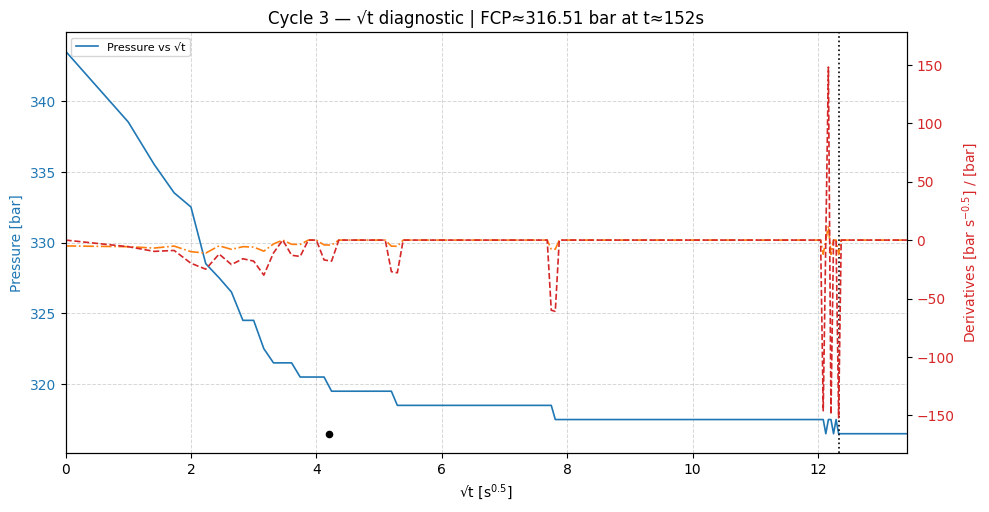

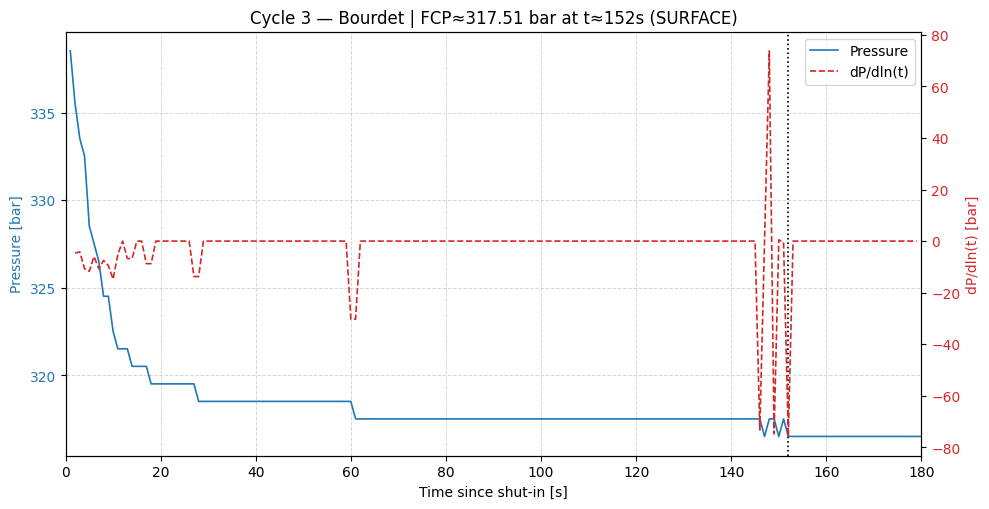

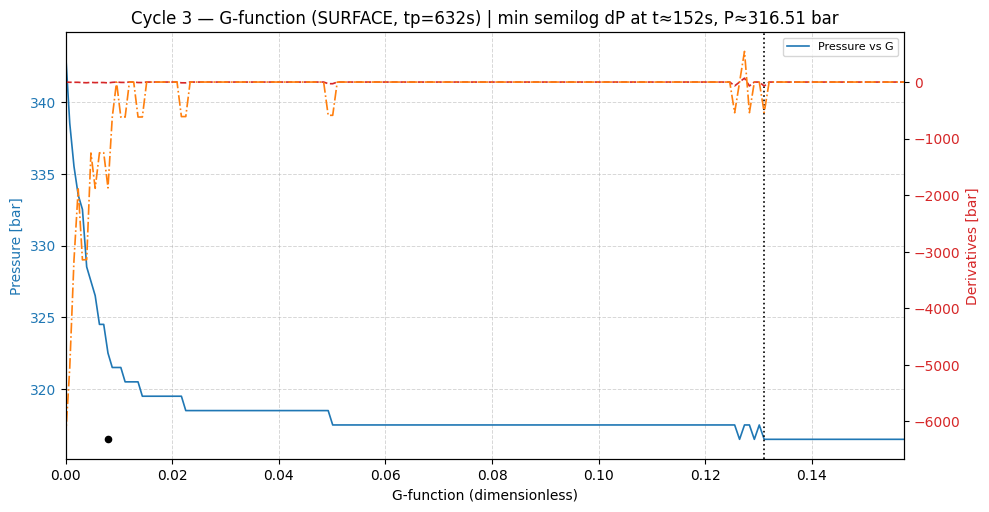

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

# Local modules
import time_difference
import well_corrections
import closure_analysis 
import plotting

CAP_S = 180

# ----------------------------
# File paths (cross-platform)
# ----------------------------
base = Path("Data") / "Amstelland"

SURF_PATH = base / "NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Cementing Unit_Data.txt"
DOWN_PATH = base / "NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Downhole Gauge_Data.TXT"

# ----------------------------
# Helpers
# ----------------------------
def to_num(series):
    """
    Normalize numeric text: strip whitespace, remove NBSPs, comma→dot, coerce to float.
    Returns a pandas Series[float].
    """
    s = pd.Series(series, copy=False)
    if s.dtype.kind in "biufc":
        return pd.to_numeric(s, errors="coerce")
    s = s.astype(str).str.strip()
    s = s.str.replace('\u00A0', '', regex=False)   # NBSP
    s = s.str.replace(',', '.', regex=False)       # decimal comma -> dot
    s = s.replace({'': None})
    return pd.to_numeric(s, errors='coerce')

def get_or_nan(df, col):
    """Return numeric series for existing column or a NaN series matching df length."""
    if col in df.columns:
        return to_num(df[col])
    return pd.Series([np.nan] * len(df), index=df.index, dtype=float)


# ----------------------------
# Example usage
# ----------------------------
dfS = pd.read_csv(SURF_PATH, sep="\t", engine="python", on_bad_lines="skip")
dfD = pd.read_csv(DOWN_PATH, sep="\t", engine="python", on_bad_lines="skip")

print("Surface data file loaded:", SURF_PATH.resolve())
print("Downhole data file loaded:", DOWN_PATH.resolve())

# Ensure expected columns exist for downhole file
dfD.columns = ['Time', 'Delta Time', 'Pressure', 'Temperature', 'None', 'None2']

# Slice away headers/units lines typical of these exports
dfS = dfS.iloc[1:].reset_index(drop=True)
dfD = dfD.iloc[4:, :-2].reset_index(drop=True)  # drop last two 'None' cols

# ----------------------------
# Parse time columns
# ----------------------------
# Surface time format: %m:%d:%Y:%H:%M:%S
time_surface = pd.to_datetime(dfS['Time'], format='%m:%d:%Y:%H:%M:%S', errors='coerce')

# Downhole time format: %d-%m-%Y %H:%M:%S
time_downhole = pd.to_datetime(dfD['Time'].astype(str).str.strip(),
                               format='%d-%m-%Y %H:%M:%S', errors='coerce')

# ----------------------------
# Numeric columns (Surface)
# ----------------------------
pressure_S          = get_or_nan(dfS, 'Treating Pressure')
flowrate_S          = get_or_nan(dfS, 'Flow Rate') * 0.06 # l/min -> m³/hour
density_S           = get_or_nan(dfS, 'Density')
volume_S            = get_or_nan(dfS, 'Volume')
tot_volume_nrd_S    = get_or_nan(dfS, 'TOT vol nrd')
volume_nrd_S        = get_or_nan(dfS, 'NRD VOLUME')
return_volume_S     = get_or_nan(dfS, 'RETURN VOL')
totbalance_volume_S = get_or_nan(dfS, 'total bla')  # may not exist in some files
RDA_pressure_S      = get_or_nan(dfS, 'RDA2 IN1')

# ----------------------------
# Numeric columns (Downhole)
# ----------------------------
delta_time_D  = to_num(dfD['Delta Time'])
pressure_D    = to_num(dfD['Pressure']) * 0.0689476  # psi -> bar
temperature_D = to_num(dfD['Temperature'])

# ----------------------------
# Time windows
# ----------------------------
startS = pd.to_datetime("2023-12-10 15:15:00")
endS   = pd.to_datetime("2023-12-10 17:30:00")

startD = pd.to_datetime("2023-12-10 14:15:00")
endD   = pd.to_datetime("2023-12-10 16:30:00")

# ----------------------------
# Masks (NaN-safe)
# ----------------------------
maskS = (
    pressure_S.notna() &
    time_surface.notna() &
    (RDA_pressure_S.fillna(np.inf) <= 2000) &
    (time_surface >= startS) & (time_surface <= endS)
)

time_S               = time_surface[maskS]
pressure_S           = pressure_S[maskS]
flowrate_S           = flowrate_S[maskS]
density_S            = density_S[maskS]
volume_S             = volume_S[maskS]
tot_volume_nrd_S     = tot_volume_nrd_S[maskS]
volume_nrd_S         = volume_nrd_S[maskS]
return_volume_S      = return_volume_S[maskS]
totbalance_volume_S  = totbalance_volume_S[maskS]
RDA_pressure_S       = RDA_pressure_S[maskS]

print('surface time min/max:', (time_surface.min(), time_surface.max()))

maskD = (
    time_downhole.notna() &
    pressure_D.notna() &
    temperature_D.notna() &
    (time_downhole >= startD) & (time_downhole <= endD)
)

time_D        = time_downhole[maskD]
delta_time_D  = delta_time_D[maskD]
pressure_D    = pressure_D[maskD]
temperature_D = temperature_D[maskD]

print('downhole time min/max:', (time_downhole.min(), time_downhole.max()))

# ----------------------------
# Surface panels
# ----------------------------
fig1, axs1 = plotting.plot_surface_panels(
    time_S, pressure_S, flowrate_S, density_S, volume_S,
    tot_volume_nrd_S, return_volume_S, totbalance_volume_S, RDA_pressure_S,
    figsize=(22, 8), markersize=0.2, linewidth=1.0, tick_labelsize=7, title_labelsize=6
)

# ----------------------------
# Triple-axis (surface subset)
# ----------------------------
fig2, (ax1, ax2, ax3) = plotting.plot_triple_axis(
    time_S, pressure_S, flowrate_S, return_volume_S,
    start=startS, end=endS, figsize=(16, 6)
)

# ----------------------------
# Downhole P/T plot
# ----------------------------
fig3, (ax4, ax5) = plotting.plot_downhole_pt(time_D, pressure_D, temperature_D, figsize=(16, 6))

# ----------------------------
# Depths & lag estimation
# ----------------------------
# Example MD/TVD arrays; replace with real values
MD = np.array([1364, 1383, 1383.3], dtype=float)
TVD = np.array([1363.18, np.nan, 1382.31], dtype=float)  # NaN = missing value
TVD_fracture_m = 1866.50
gauge_index    = 1  # index of the downhole gauge in the MD/TVD arrays

# NOTE: we use the (MD, TVD, gauge_index, TVD_fracture_m) signature per the fixed helper
TVD_interp, TVD_gauge_m, delta_tvd_m = well_corrections.estimate_lag(MD, TVD, gauge_index, TVD_fracture_m)

# Estimate delay (surface vs downhole)
try:
    lag_s, grid_step = time_difference.estimate_delay_seconds_robust(
        time_surface, pressure_S,
        time_downhole, pressure_D,
        max_lag_s=4*3600,    # 4 hours
        detrend_window_s=120
    )
except Exception as e:
    print("Delay estimation failed; defaulting lag_s=0. Reason:", e)
    lag_s = 0.0
print(f"Estimated delay: {float(lag_s)/3600:.2f} h")
# To align SURFACE to DOWNHOLE we shift SURFACE by **-lag_s**.

# ----------------------------
# Hydrostatic corrections to fracture depth
# ----------------------------
# Surface pressure corrected to fracture (if surface sensor is at TVD≈0, ΔTVD≈TVD_fracture_m)
p_surface_corr, _ = well_corrections.hydrostatic_correct_to_fracture(
    p_gauge=pressure_S,      # SURFACE treating pressure [bar]
    time_gauge=time_S,
    rho_surface=density_S,   # surface density series
    time_surface=time_S,
    delta_tvd_m=TVD_fracture_m,  # surface(0) -> fracture
    out_units='bar',
    lag_s=None
)

# Downhole gauge corrected to fracture
p_downhole_corr, _ = well_corrections.hydrostatic_correct_to_fracture(
    p_gauge=pressure_D,      # DOWNHOLE gauge [bar]
    time_gauge=time_D,
    rho_surface=density_S,   # use surface density aligned to DH via lag_s
    time_surface=time_S,
    delta_tvd_m=delta_tvd_m, # TVD_fracture - TVD_gauge
    out_units='bar',
    lag_s=lag_s
)

# ----------------------------
# Build aligned timelines (DOWNHOLE clock)
# ----------------------------
surface_dt_orig  = pd.to_datetime(time_S)
downhole_dt_orig = pd.to_datetime(time_D)

# Shift SURFACE timestamps by **-lag_s** to align onto DOWNHOLE clock
surface_dt_aligned_to_dh = surface_dt_orig - pd.to_timedelta(float(lag_s), unit='s')

y_surface  = pd.Series(p_surface_corr, copy=False).astype(float).to_numpy()
y_downhole = pd.Series(p_downhole_corr, copy=False).astype(float).to_numpy()

# Plot alignment (datetime)
figA, axA = plotting.plot_alignment(surface_dt_aligned_to_dh, y_surface, downhole_dt_orig, y_downhole, figsize=(16, 6))

# ----------------------------
# Closure analysis (SURFACE time basis) — single cycle
# ----------------------------
# 1) Auto shut-in detection on SURFACE clock
t_shut_in_auto_surface = closure_analysis.find_shut_in_time_from_flow(
    time_S, flowrate_S, threshold=0.1, min_hold_s=10
)
print("Auto-detected shut-in (surface clock):", t_shut_in_auto_surface)

# Fallback if not found
t_shut_in_surface = (
    t_shut_in_auto_surface if t_shut_in_auto_surface is not None
    else pd.to_datetime(time_S.iloc[-1])
)

# 2) Build SURFACE falloff (SURFACE clock) and hard-cap to 180 s for analysis
#    Use p_surface_corr (already corrected to fracture) to interpret at fracture depth
ts_surf, p_surf = closure_analysis.build_shut_in_series(time_S, p_surface_corr, t_shut_in_surface)
if len(ts_surf) == 0:
    raise RuntimeError("No SURFACE samples at/after shut-in.")
cap_s = 180.0
keep = (ts_surf <= cap_s)
ts_surf, p_surf = ts_surf[keep], p_surf[keep]
print(f"[SURFACE] Falloff samples (capped): {len(ts_surf)}; duration = {ts_surf[-1]:.1f} s")

# Helper: estimate last pump-start (surface clock) before shut-in
def _last_pump_start_before_shutin(time_s, q_m3h, t_shut_s, q_low=None, q_high=None):
    t = pd.to_datetime(pd.Series(time_s))
    q = pd.Series(q_m3h, dtype=float)

    # Adaptive hysteresis if not given
    if q_high is None or q_low is None:
        qpos = q[q > 0].dropna()
        if len(qpos):
            q_high = max(0.3, qpos.quantile(0.15)) if q_high is None else q_high
            q_low  = max(0.1, qpos.quantile(0.02)) if q_low  is None else q_low
        else:
            q_high = 0.3 if q_high is None else q_high
            q_low  = 0.1 if q_low  is None else q_low

    m = (t < t_shut_s) & q.notna()
    t, q = t[m].reset_index(drop=True), q[m].reset_index(drop=True)
    if len(t) < 2:
        return None

    state = 'idle'
    last_start = None
    for i in range(len(t)):
        if state == 'idle' and q.iloc[i] >= q_high:
            last_start = t.iloc[i]
            state = 'pumping'
        elif state == 'pumping' and q.iloc[i] <= q_low:
            state = 'idle'
    return last_start

# 3) Estimate pumping time tp_s for G-function (surface clock ⇒ seconds)
t_pump_start_surface = _last_pump_start_before_shutin(time_S, flowrate_S, t_shut_in_surface)
if t_pump_start_surface is not None:
    tp_s = (t_shut_in_surface - t_pump_start_surface).total_seconds()
else:
    tp_s = 0.0
# Safe fallback to avoid tp=0
if not np.isfinite(tp_s) or tp_s <= 0:
    tp_s = max(1.0, float(ts_surf[0]))




q_low, q_high = closure_analysis.suggest_flow_thresholds(flowrate_S)

cycles = closure_analysis.detect_pump_cycles(
    time_S=time_S,
    q_m3h=flowrate_S,
    return_vol_S=return_volume_S,
    q_low=q_low, q_high=q_high,
    min_hold_s=30,
    min_gap_s=60,
    flowback_rate_thresh=0.2
)
print(f"Detected {len(cycles)} cycles.")



Detected 3 cycles.

Per-cycle closure analysis on SURFACE pressure (Bourdet, √t & G within 0–180 s):
  Cycle 1: FCP (√t inters.) ≈ 315.51 bar at t ≈ 28 s
            FCP (G inters.)  ≈ 315.51 bar at t ≈ 12 s (tp=459s)
  Cycle 2: FCP (√t inters.) ≈ 315.51 bar at t ≈ 102 s
            FCP (G inters.)  ≈ 315.51 bar at t ≈ 20 s (tp=118s)
  Cycle 3: FCP (√t inters.) ≈ 316.51 bar at t ≈ 18 s
            FCP (G inters.)  ≈ 316.51 bar at t ≈ 10 s (tp=632s)


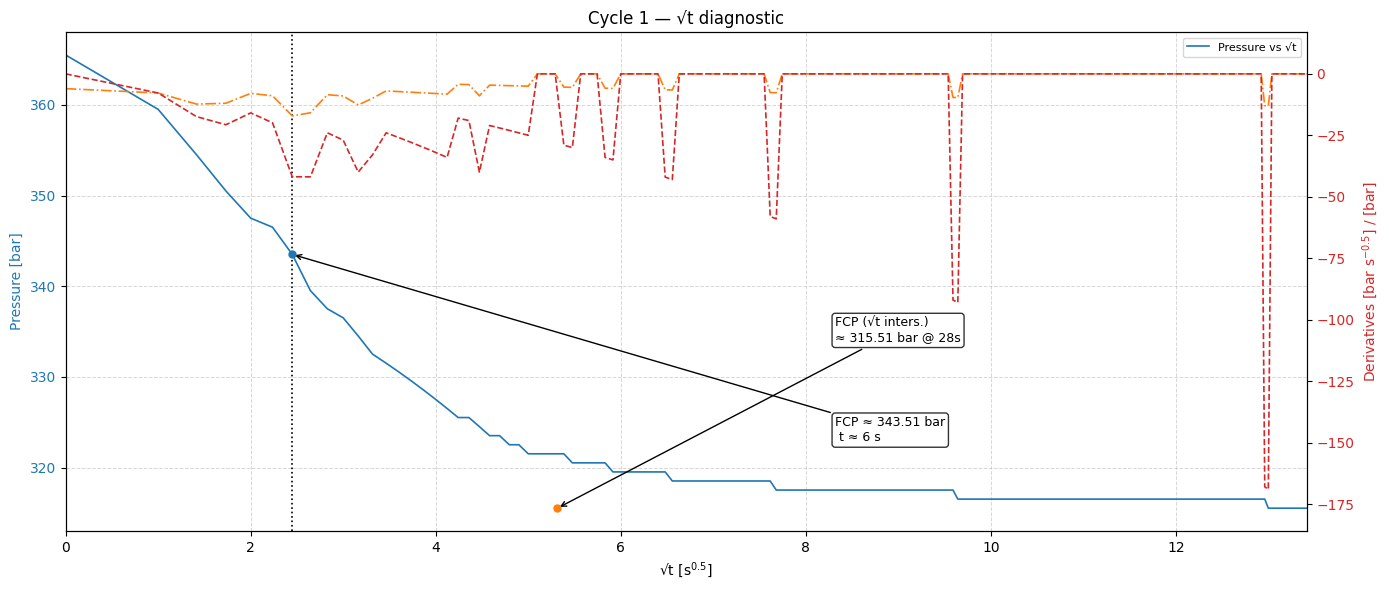

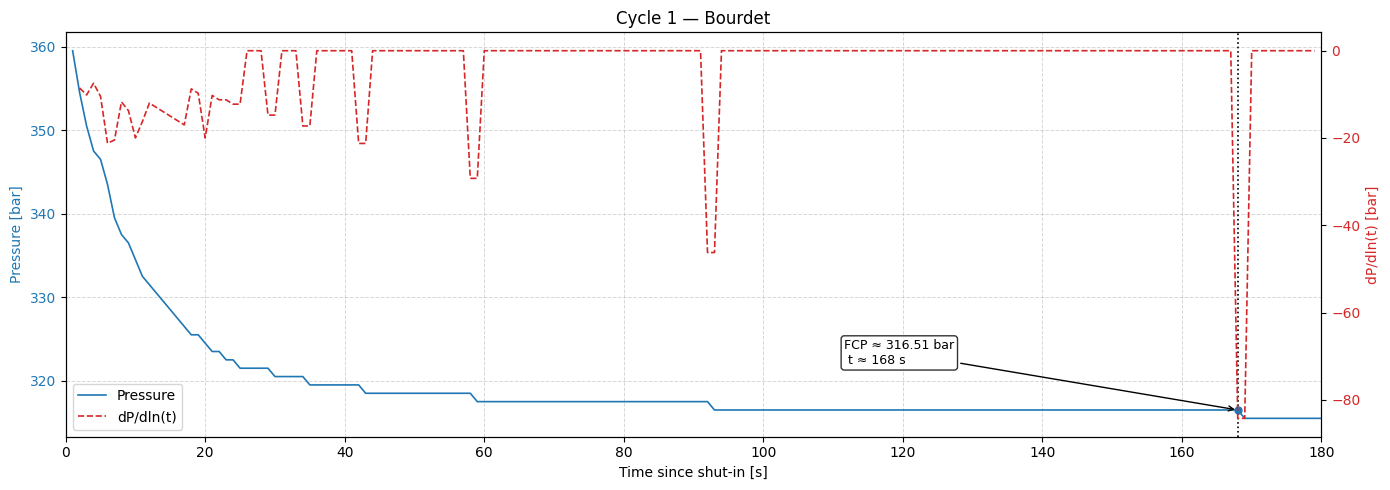

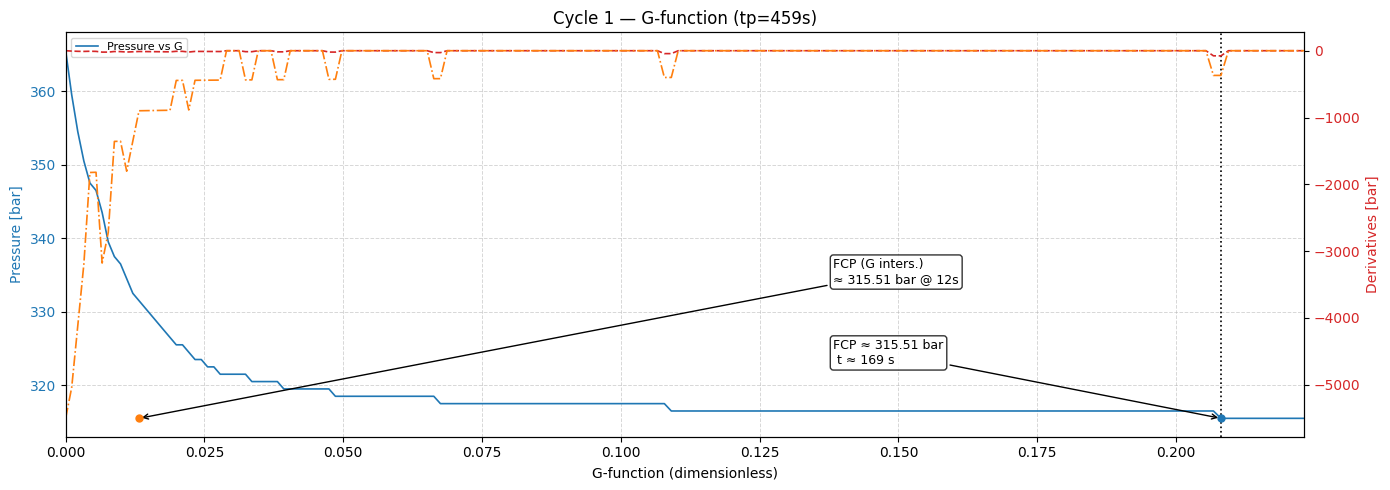

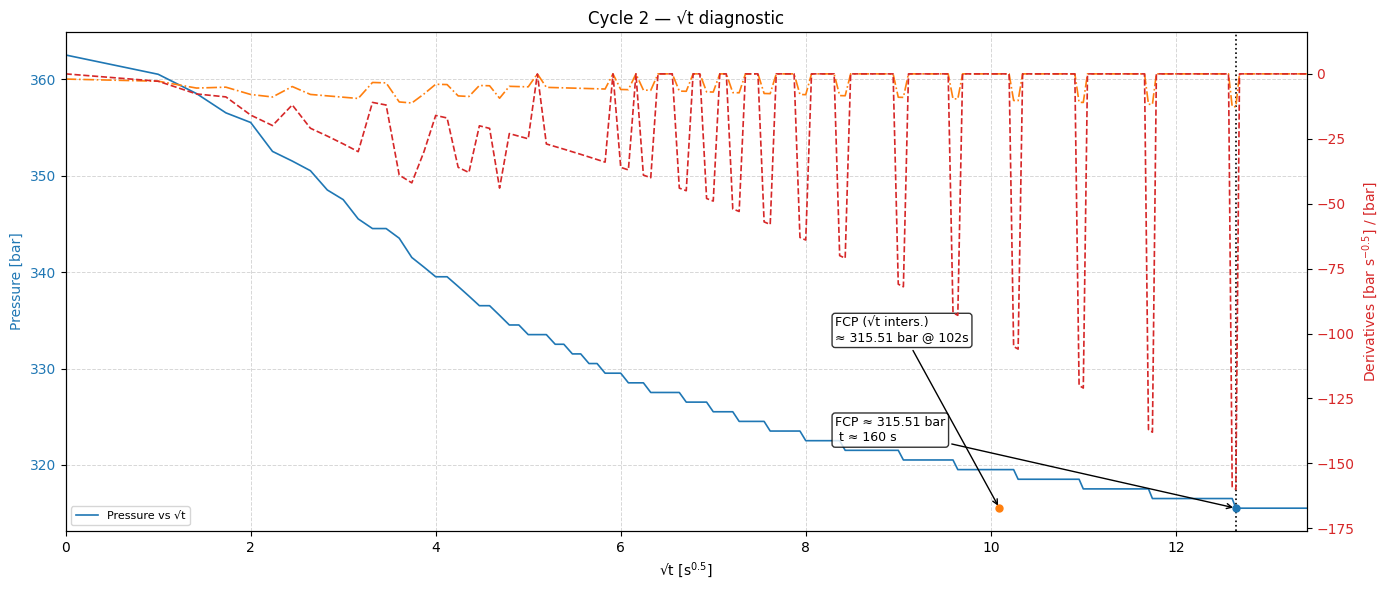

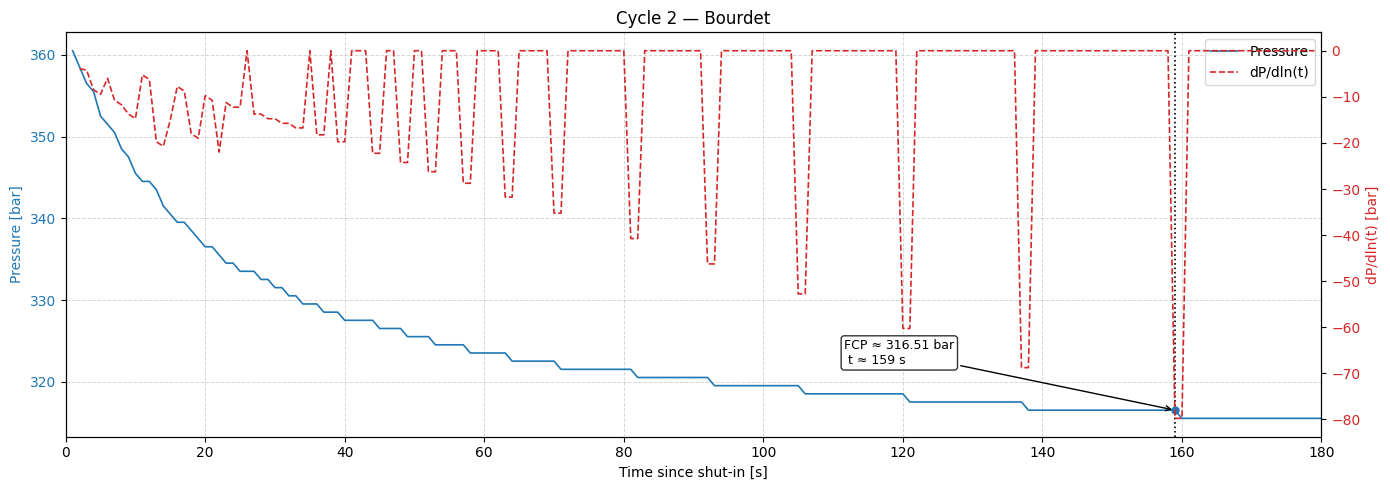

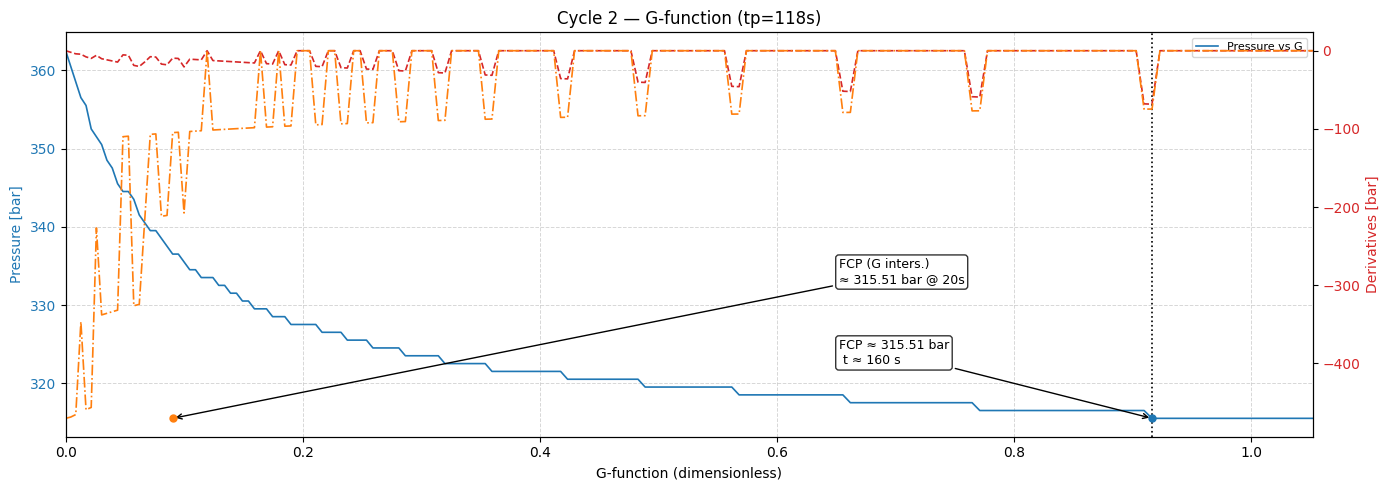

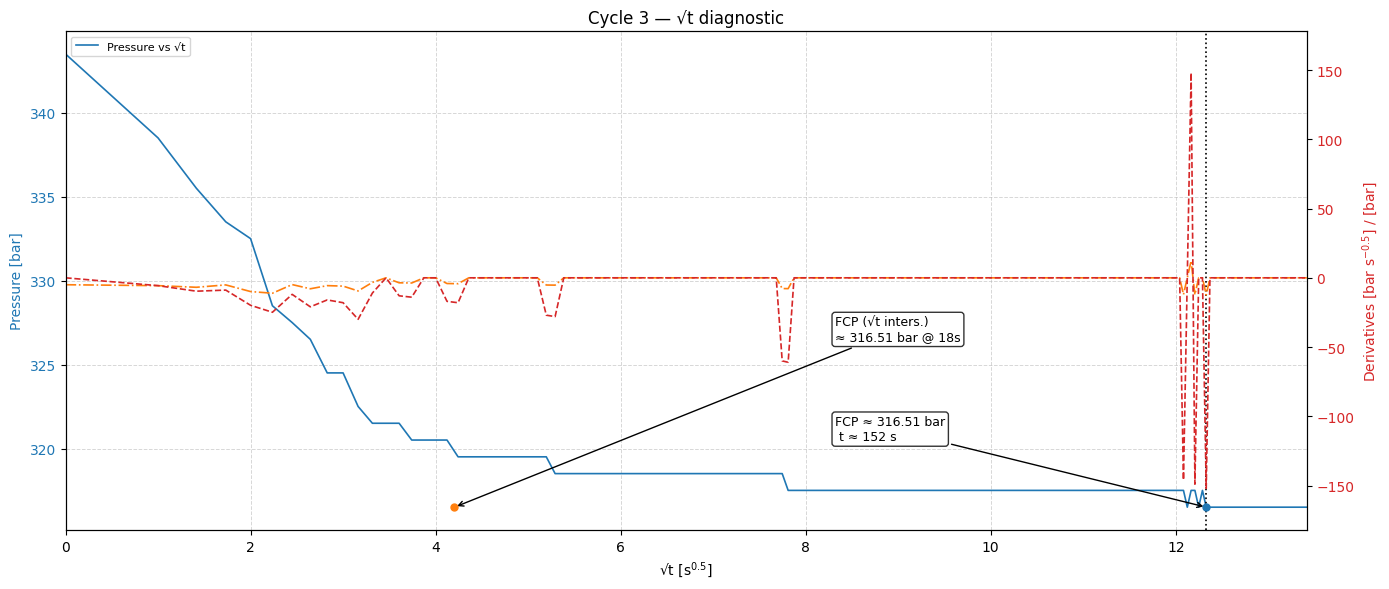

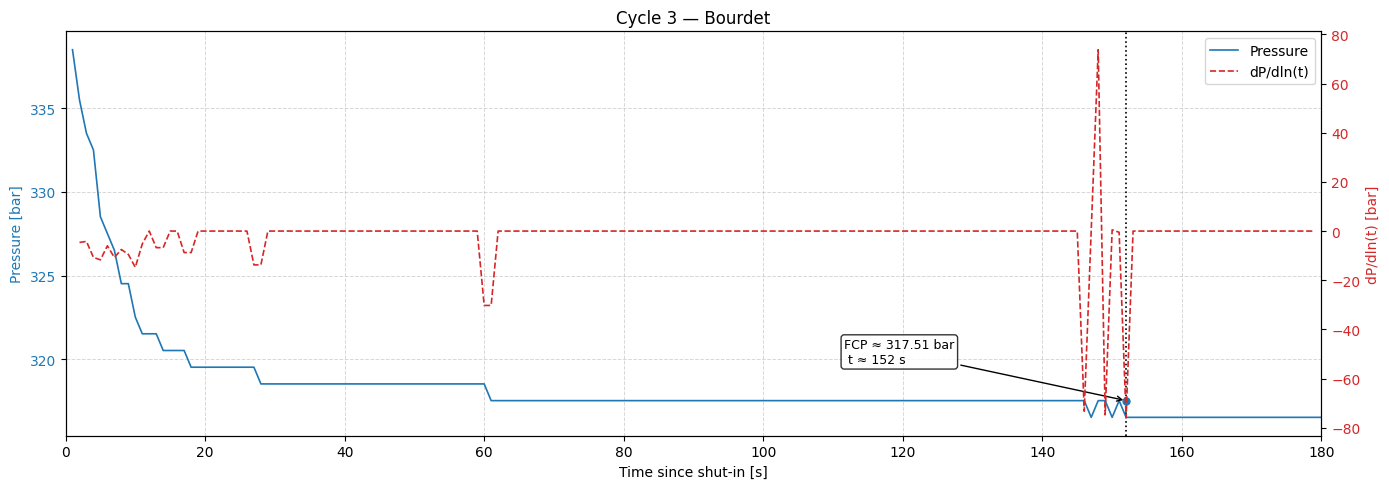

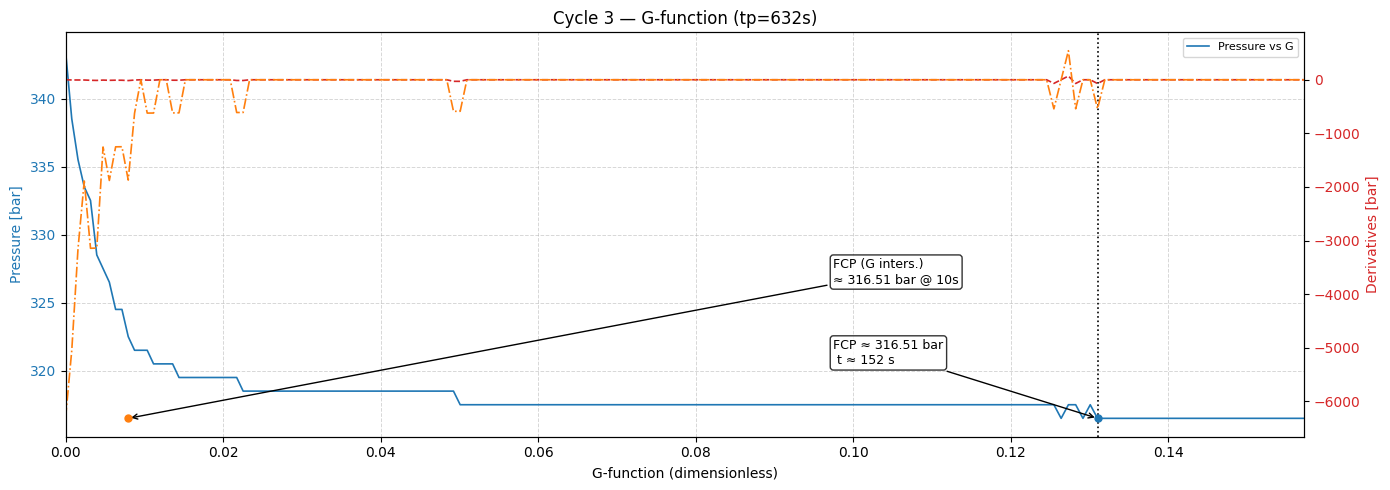

In [10]:
# ============================
# CYCLE DETECTION (SURFACE)
# ============================
q_low, q_high = closure_analysis.suggest_flow_thresholds(flowrate_S)

cycles = closure_analysis.detect_pump_cycles(
    time_S=time_S,
    q_m3h=flowrate_S,
    return_vol_S=return_volume_S,   # or None if not available
    q_low=q_low, q_high=q_high,
    min_hold_s=30,
    min_gap_s=60,
    flowback_rate_thresh=0.2
)
print(f"Detected {len(cycles)} cycles.")

# ============================
# PER-CYCLE SURFACE ANALYSIS
# ============================
MIN_T_S_FOR_PICK = 0          # set >0 to ignore very early times
CAP_PER = 180.0               # cap each falloff to 180 s (or cycle duration, whichever is smaller)

def _annot(ax, x, y, text, xytext_frac=(0.65, 0.15), fontsize=9):
    """Neat anchored annotation with arrow; xy in data coords, xytext in axes fraction."""
    try:
        ax.annotate(
            text,
            xy=(x, y),
            xytext=xytext_frac, textcoords="axes fraction",
            arrowprops=dict(arrowstyle="->"),
            fontsize=fontsize,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8)
        )
    except Exception:
        pass

if len(cycles) == 0:
    print("No cycles detected — nothing to analyze.")
else:
    print("\nPer-cycle closure analysis on SURFACE pressure (Bourdet, √t & G within 0–180 s):")

    for i, cyc in enumerate(cycles, 1):
        # ---- SURFACE cycle window ----
        t_shut_S = pd.to_datetime(cyc['t_shut_in_surface'])
        t_end_S  = pd.to_datetime(cyc['t_end_surface'])

        # Build SURFACE falloff from shut-in
        ts_s, p_s = closure_analysis.build_shut_in_series(time_S, p_surface_corr, t_shut_S)

        # Cap to cycle end & CAP_PER
        t_end_rel = max(0.0, (t_end_S - t_shut_S).total_seconds())
        cap_local = min(CAP_PER, t_end_rel)
        keep = (ts_s <= cap_local)
        ts_s, p_s = ts_s[keep], p_s[keep]

        # Require sufficient usable falloff
        if len(ts_s) < 3 or (ts_s[-1] if len(ts_s) else 0.0) < 120.0:
            print(f"  Cycle {i}: skipped (too short SURFACE falloff: {ts_s[-1] if len(ts_s) else 0:.0f}s).")
            continue

        # ---- Bourdet pick (global min) on SURFACE ----
        t_log, dP_dlogt = closure_analysis.bourdet_derivative(
            ts_s, p_s, smooth_win=None, max_t_s=cap_local
        )
        i_brd = closure_analysis.suggest_closure_from_bourdet(
            t_log, dP_dlogt, min_t_s=MIN_T_S_FOR_PICK, max_t_s=cap_local
        )

        # ---- √t diagnostic on SURFACE ----
        x_sqrt, p_srt, dpdx = closure_analysis.derivative_vs_sqrt_time(
            ts_s, p_s, max_t_s=cap_local
        )
        i_srt = closure_analysis.suggest_closure_from_srt(
            x_sqrt, p_srt, dpdx, min_t_s=MIN_T_S_FOR_PICK, max_t_s=cap_local
        )

        # ---- G-function diagnostic on SURFACE ----
        try:
            tp_s = (pd.to_datetime(cyc['t_shut_in_surface']) -
                    pd.to_datetime(cyc['t_pump_start_surface'])).total_seconds()
        except Exception:
            tp_s = 0.0
        if not np.isfinite(tp_s) or tp_s <= 0:
            tp_s = max(1.0, float(ts_s[0]) if len(ts_s) else 1.0)

        G = closure_analysis.g_function_high_efficiency(ts_s, tp_s)
        semilog_dP = closure_analysis.semilog_derivative(G, p_s)
        i_g = None
        if len(G) >= 3 and np.isfinite(semilog_dP).any():
            mwin = ((ts_s >= float(MIN_T_S_FOR_PICK)) &
                    (ts_s <= float(cap_local)) &
                    np.isfinite(semilog_dP))
            if mwin.any():
                idx = np.where(mwin)[0]
                i_g = idx[np.nanargmin(semilog_dP[idx])]

        # ===========================
        # √t PLOT (short titles + annotations)
        # ===========================
        figSRT, (ax_left_srt, ax_right_srt) = plotting.plot_srt(
            x_sqrt, p_srt, dpdx, i_cl=i_srt, cap_s=cap_local
        )
        figSRT.set_size_inches(14, 6)
        ax_left_srt.set_title(f"Cycle {i} — √t diagnostic")
        #ax_right_srt.set_title("Derivatives (dP/d√t, √t·dP/d√t)")

        # annotate √t pick
        if i_srt is not None:
            t_cl_srt = float(x_sqrt[i_srt]**2)
            p_cl_srt = float(p_srt[i_srt])
            ax_left_srt.scatter([np.sqrt(t_cl_srt)], [p_cl_srt], s=25, zorder=5)
            _annot(ax_left_srt, np.sqrt(t_cl_srt), p_cl_srt,
                   f"FCP ≈ {p_cl_srt:.2f} bar\n t ≈ {t_cl_srt:.0f} s",
                   xytext_frac=(0.62, 0.18))

        # √t intersection overlay + annotation
        try:
            res_srt = closure_analysis.fcp_by_sqrt_intersection(
                ts_s, p_s, max_t_s=cap_local, min_left=8, min_right=8
            )
        except Exception:
            res_srt = {"ok": False}

        if res_srt.get("ok"):
            cp_bar = float(res_srt.get("closure_pressure_bar", np.nan))
            ct_s   = float(res_srt.get("closure_time_s", np.nan))
            if np.isfinite(cp_bar) and np.isfinite(ct_s):
                print(f"  Cycle {i}: FCP (√t inters.) ≈ {cp_bar:.2f} bar at t ≈ {ct_s:.0f} s")
                # draw lines on left panel (x=√t domain)
                left_fit  = res_srt.get("left_fit",  (np.nan, np.nan))
                right_fit = res_srt.get("right_fit", (np.nan, np.nan))
                mL, bL = map(float, left_fit)
                mR, bR = map(float, right_fit)
                x_cl = np.sqrt(ct_s) if np.isfinite(ct_s) and ct_s >= 0 else np.nan
                if np.isfinite(x_cl):
                    xL = x_sqrt[x_sqrt <= x_cl]
                    xR = x_sqrt[x_sqrt >= x_cl]
                    if np.isfinite(mL) and np.isfinite(bL) and len(xL) > 1:
                        ax_left_srt.plot(xL, mL * xL + bL, ls="--", lw=1.2, label="√t left fit")
                    if np.isfinite(mR) and np.isfinite(bR) and len(xR) > 1:
                        ax_left_srt.plot(xR, mR * xR + bR, ls="--", lw=1.2, label="√t right fit")
                    ax_left_srt.scatter([x_cl], [cp_bar], s=25, zorder=5)
                    _annot(ax_left_srt, x_cl, cp_bar,
                           f"FCP (√t inters.)\n≈ {cp_bar:.2f} bar @ {ct_s:.0f}s",
                           xytext_frac=(0.62, 0.38))
                try:
                    ax_left_srt.legend(fontsize=8, loc="best")
                except Exception:
                    pass

        figSRT.tight_layout()

        # ===========================
        # BOURDET PLOT (short titles + annotations)
        # ===========================
        figBRD, axBRD = plotting.plot_bourdet(
            t_log, dP_dlogt, p=p_s, p_times=ts_s, i_cl=i_brd, cap_s=cap_local
        )
        figBRD.set_size_inches(14, 5)
        axBRD.set_title(f"Cycle {i} — Bourdet")
        if i_brd is not None:
            axBRD.scatter([t_log[i_brd]], [p_s[i_brd]], s=25, zorder=5)
            _annot(axBRD, t_log[i_brd], p_s[i_brd],
                   f"FCP ≈ {p_s[i_brd]:.2f} bar\n t ≈ {t_log[i_brd]:.0f} s",
                   xytext_frac=(0.62, 0.18))
        figBRD.tight_layout()

        # ===========================
        # G-FUNCTION PLOT (short titles + annotations)
        # ===========================
        figG, axG = plotting.plot_gfunction(
            ts_seconds=ts_s, p=p_s, tp_seconds=tp_s, p_times=ts_s, i_cl=i_g, cap_s=cap_local
        )
        figG.set_size_inches(14, 5)
        axG.set_title(f"Cycle {i} — G-function (tp={tp_s:.0f}s)")
        if i_g is not None:
            axG.scatter([G[i_g]], [p_s[i_g]], s=25, zorder=5)
            _annot(axG, G[i_g], p_s[i_g],
                   f"FCP ≈ {p_s[i_g]:.2f} bar\n t ≈ {ts_s[i_g]:.0f} s",
                   xytext_frac=(0.62, 0.18))

        # G intersection overlay + annotation
        try:
            res_g = closure_analysis.fcp_by_g_intersection(
                ts_s, p_s, tp_seconds=tp_s, max_t_s=cap_local, min_left=8, min_right=8
            )
        except Exception:
            res_g = {"ok": False}

        if res_g.get("ok"):
            cp_bar_g = float(res_g.get("closure_pressure_bar", np.nan))
            ct_s_g   = float(res_g.get("closure_time_s", np.nan))
            if np.isfinite(cp_bar_g) and np.isfinite(ct_s_g):
                print(f"            FCP (G inters.)  ≈ {cp_bar_g:.2f} bar at t ≈ {ct_s_g:.0f} s (tp={tp_s:.0f}s)")
                left_fit_g  = res_g.get("left_fit",  (np.nan, np.nan))
                right_fit_g = res_g.get("right_fit", (np.nan, np.nan))
                mL_g, bL_g = map(float, left_fit_g)
                mR_g, bR_g = map(float, right_fit_g)

                # closure G value
                G_cl = res_g.get("closure_G", None)
                if G_cl is not None:
                    try:
                        G_cl = float(G_cl)
                    except Exception:
                        G_cl = np.nan
                else:
                    if np.isfinite(ct_s_g):
                        k = int(np.argmin(np.abs(ts_s - ct_s_g)))
                        G_cl = G[k] if 0 <= k < len(G) else np.nan
                    else:
                        G_cl = np.nan

                # draw fits and annotate
                if np.isfinite(G_cl):
                    GL = G[G <= G_cl]
                    GR = G[G >= G_cl]
                else:
                    GL = GR = G

                if np.isfinite(mL_g) and np.isfinite(bL_g) and len(GL) > 1:
                    axG.plot(GL, mL_g * GL + bL_g, ls="--", lw=1.2, label="G left fit")
                if np.isfinite(mR_g) and np.isfinite(bR_g) and len(GR) > 1:
                    axG.plot(GR, mR_g * GR + bR_g, ls="--", lw=1.2, label="G right fit")

                if np.isfinite(G_cl) and np.isfinite(cp_bar_g):
                    axG.scatter([G_cl], [cp_bar_g], s=25, zorder=5)
                    _annot(axG, G_cl, cp_bar_g,
                           f"FCP (G inters.)\n≈ {cp_bar_g:.2f} bar @ {ct_s_g:.0f}s",
                           xytext_frac=(0.62, 0.38))

                try:
                    axG.legend(fontsize=8, loc="best")
                except Exception:
                    pass

        figG.tight_layout()

# (Optional) bring all windows tight
plt.tight_layout()
plt.show()

Detected 3 cycles.

Per-cycle closure analysis on SURFACE pressure (Bourdet, √t & G within 0–180 s):
  Cycle 1: FCP (√t inters.) ≈ 315.51 bar at t ≈ 28 s
            FCP (G inters.)  ≈ 315.51 bar at t ≈ 12 s (tp=459s)
  Cycle 2: FCP (√t inters.) ≈ 315.51 bar at t ≈ 102 s
            FCP (G inters.)  ≈ 315.51 bar at t ≈ 20 s (tp=118s)
  Cycle 3: FCP (√t inters.) ≈ 316.51 bar at t ≈ 18 s
            FCP (G inters.)  ≈ 316.51 bar at t ≈ 10 s (tp=632s)


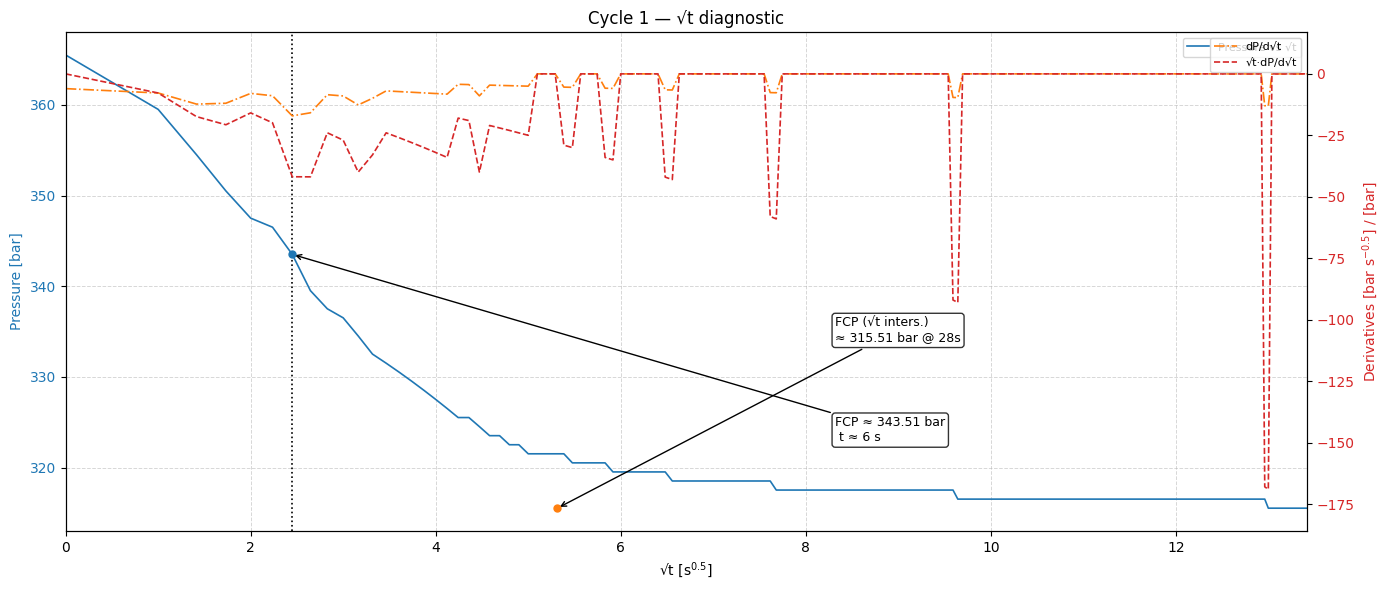

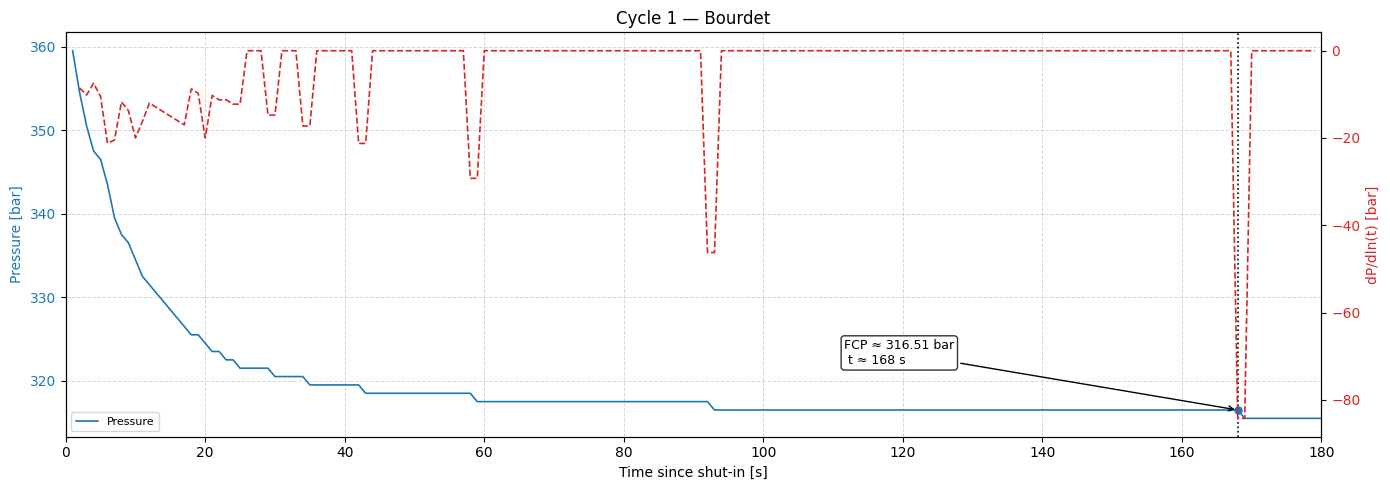

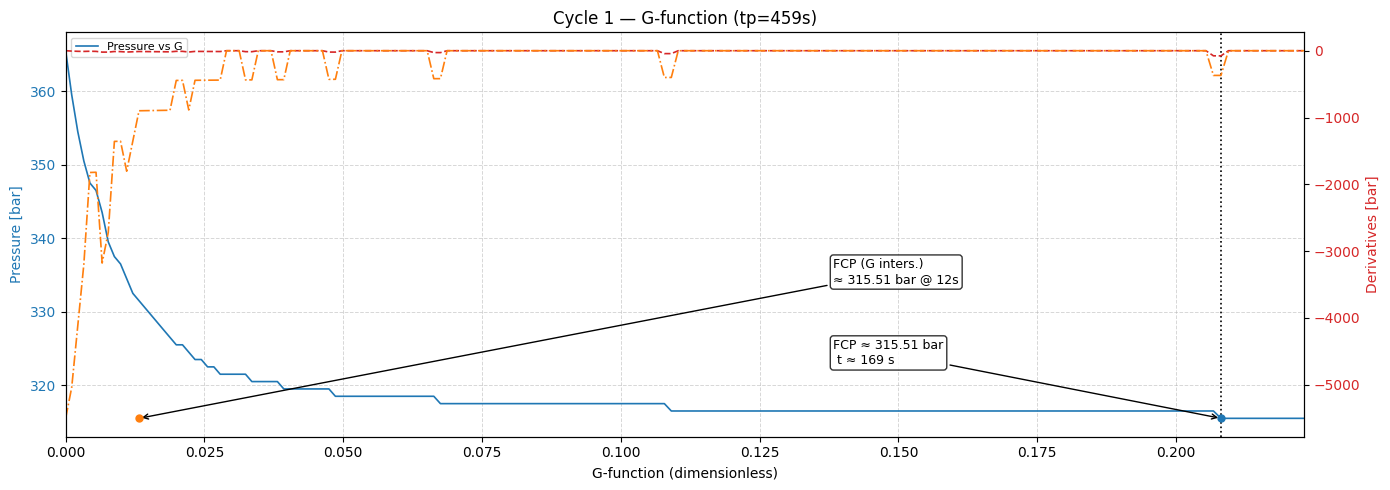

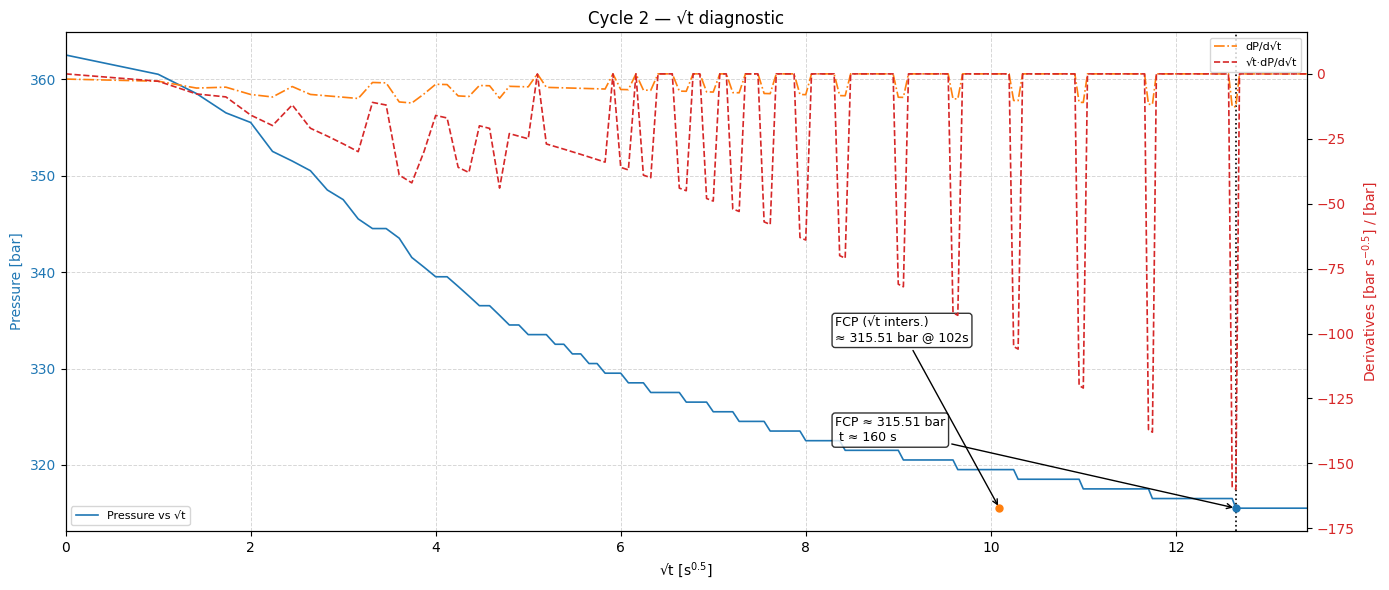

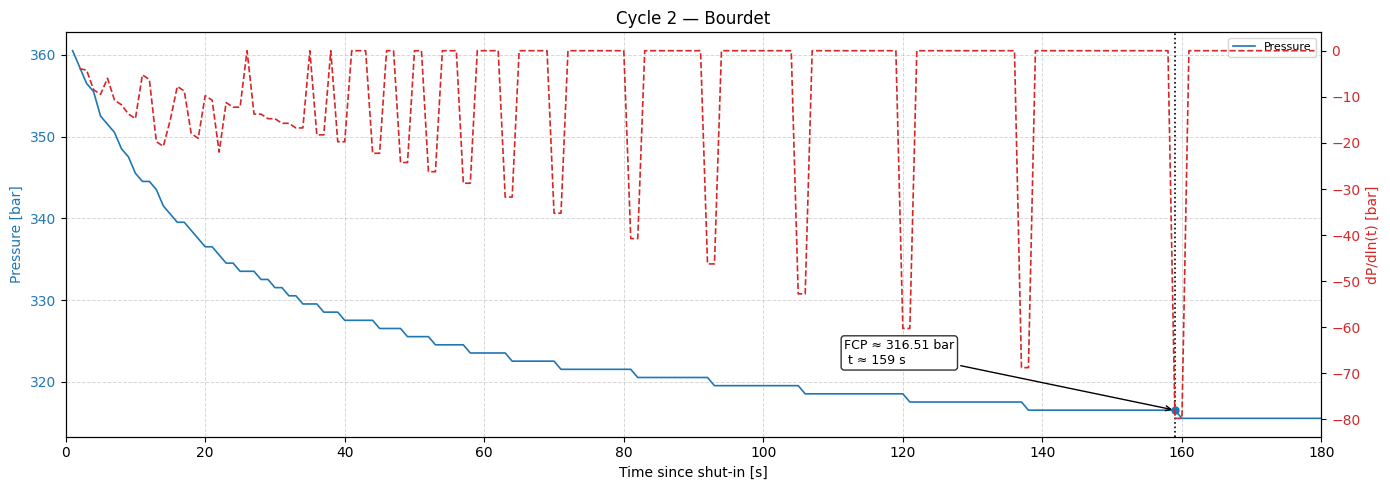

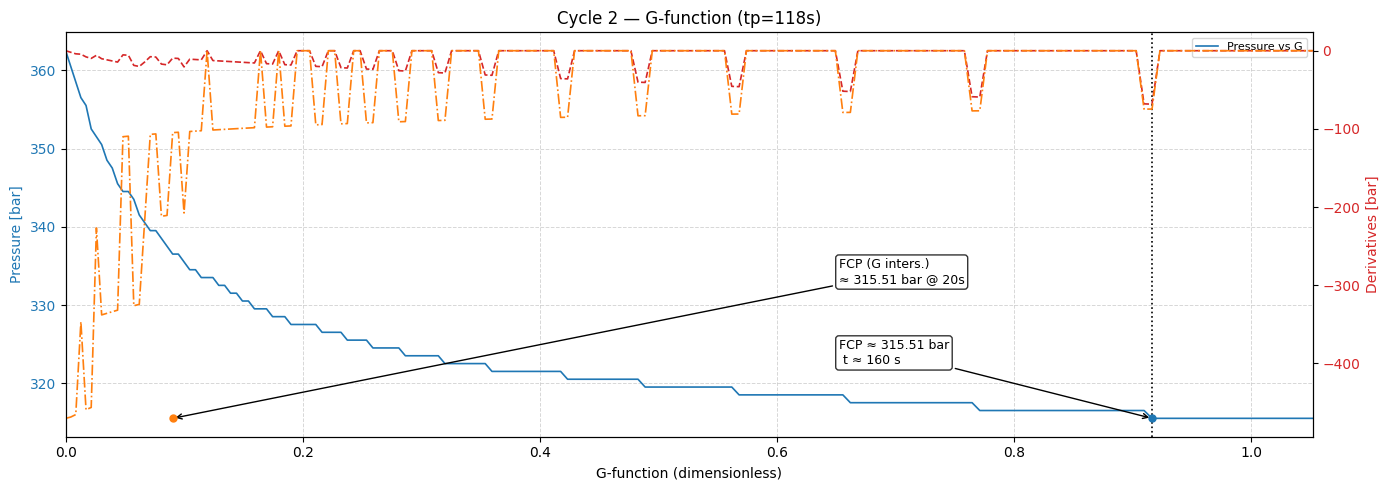

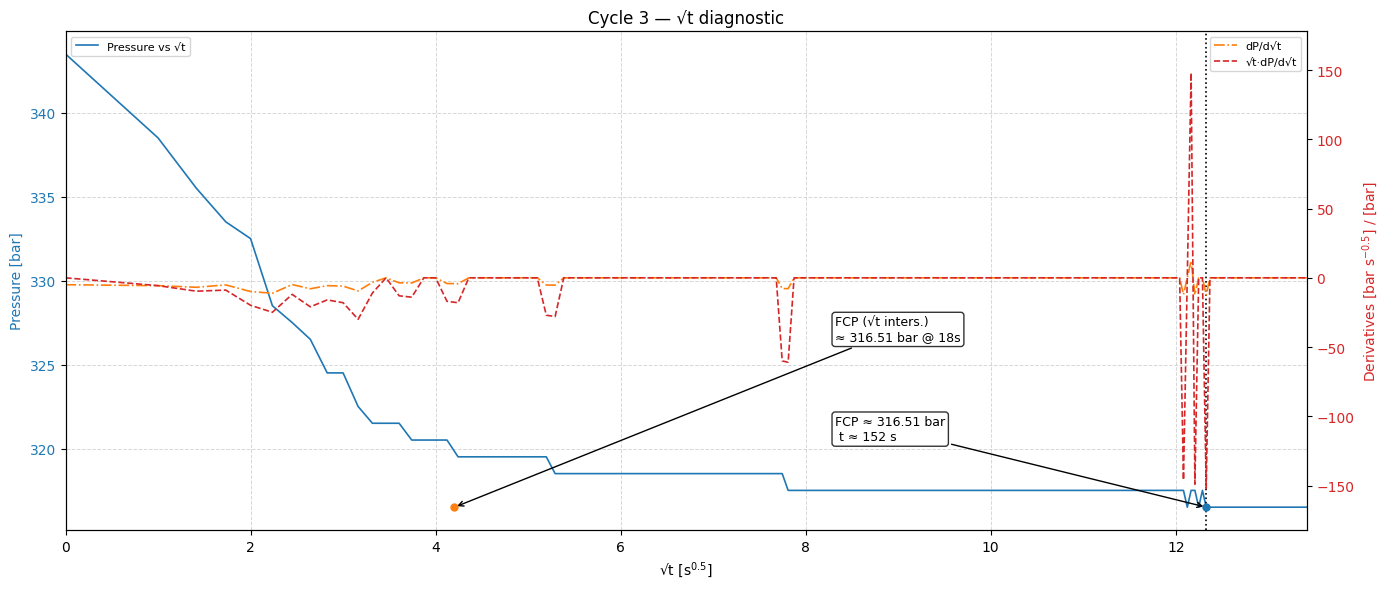

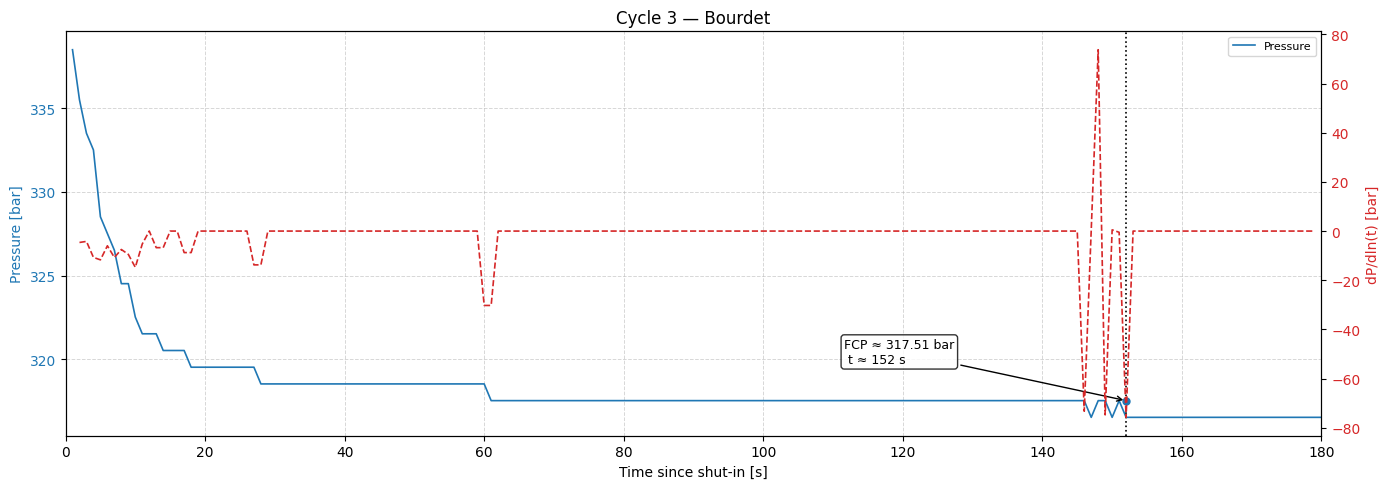

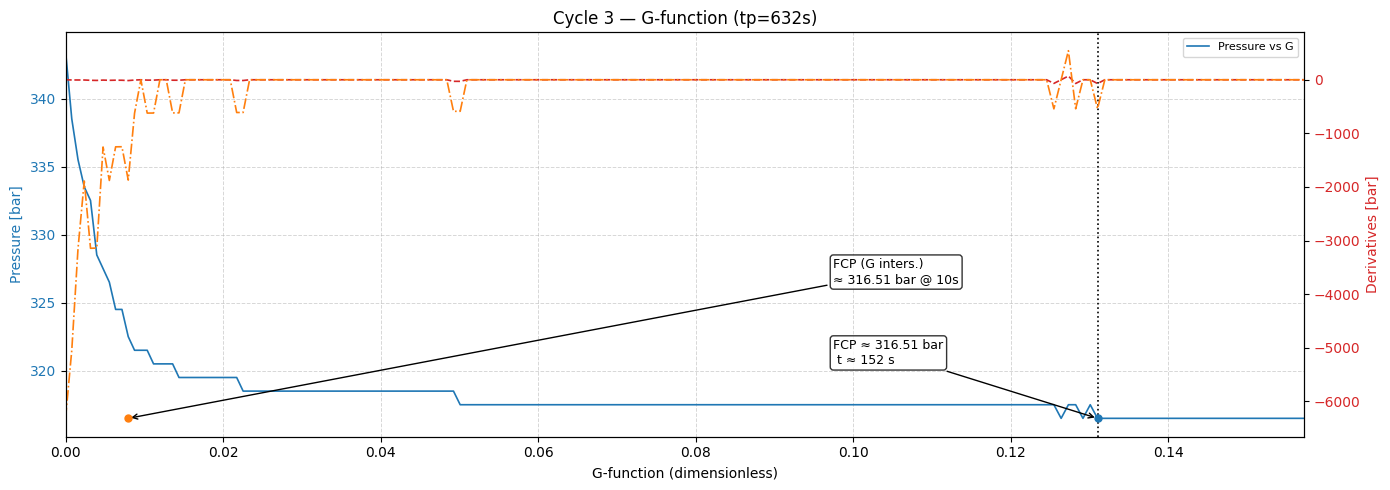